In [59]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis

import matplotlib.pyplot as plt

# Tensorflow Test

In [3]:
# https://github.com/GPflow/GPflow/issues/439
def tf_tril_indices(N, k=0):
    M1 = tf.tile(tf.expand_dims(tf.range(N), axis=0), [N,1])
    M2 = tf.tile(tf.expand_dims(tf.range(N), axis=1), [1,N])
    mask = (M1-M2) >= -k
    ix1 = tf.boolean_mask(M2, tf.transpose(mask))
    ix2 = tf.boolean_mask(M1, tf.transpose(mask))
    return ix1, ix2

In [174]:
def ard_kernel(X1, X2, gamma=1., alphas=None):
    # X1:  (n1 x d)
    # X2:  (n2 x d)
    # out: (n1 x n2
    with tf.name_scope('ard_kernel'):
        if alphas is None:
            alphas = tf.ones([tf.shape(X1)[1]])
        return gamma * tf.reduce_prod(tf.exp(- (tf.expand_dims(X1, 1) - tf.expand_dims(X2, 0))**2 / (2 * tf.expand_dims(tf.expand_dims(alphas, 0), 0))), axis=2) 


def mu_tilde_square(X_data, Z, m, Kzz_inv):
    k_zx = ard_kernel(X_data, Z, alphas=a_const)
    k_xz = tf.transpose(k_zx)
    k_xx = ard_kernel(X_data, Z, alphas=a_const)
    mu_sqr = tf.matmul(tf.matmul(tf.matmul(tf.matmul(tf.matmul(tf.transpose(tf.expand_dims(m,1)),Kzz_inv)
                                                     ,k_zx),k_xz),Kzz_inv),tf.expand_dims(m,1))
    sig_sqr = k_xx - tf.trace(tf.matmul(tf.matmul(Kzz_inv,k_zx),k_xz)) + tf.trace(
        tf.matmul(tf.matmul(tf.matmul(tf.matmul(Kzz_inv,S),Kzz_inv),k_zx),k_xz))
    return mu_sqr, sig_sqr

def kl_term(m, S, K_zz, K_zz_inv, u_ovln):
    # mean_diff = (u_ovln * tf.ones([tf.shape(Z_ph)[0]]) - m)
    mean_diff = tf.expand_dims(u_ovln * tf.ones([tf.shape(Z_ph)[0]]) - m, 1)
    first  = tf.trace(tf.matmul(K_zz_inv, S))
    second = tf.log(tf.matrix_determinant(K_zz) / tf.matrix_determinant(S))
    third  = tf.to_float(tf.shape(m)[0])
    # fourth = tf.reduce_sum(tf.multiply(tf.reduce_sum(tf.multiply(mean_diff, tf.transpose(K_zz_inv)), axis=1) , mean_diff))
    
    fourth = tf.squeeze(tf.matmul(tf.matmul(tf.transpose(mean_diff), K_zz_inv), mean_diff))
    
    return 0.5 * (first  + second - third + fourth)

def psi_term(Z1, Z2,a,g,Tmin,Tmax):
    z_ovln = (tf.expand_dims(Z1,1)+tf.expand_dims(Z2,0))/2
    a_r = tf.expand_dims(tf.expand_dims(a,0),1)
    
    pi = tf.constant(math.pi)
    
    return g**2 * tf.reduce_prod(-(tf.sqrt(pi * a_r)/2
                   ) * tf.exp(-tf.pow(tf.expand_dims(Z1,1) - tf.expand_dims(Z2,0),2) / (4 * a_r)
                             ) * tf.erf((z_ovln-tf.expand_dims(tf.expand_dims(Tmax,0),1))/tf.sqrt(a_r)
                                     ) - tf.erf((z_ovln-tf.expand_dims(tf.expand_dims(Tmin,0),1))/tf.sqrt(a_r)),2)

def T_Integral(m, S, Kzz_inv,psi, g,Tmin, Tmax):
    #e_qf = tf.matmul(m,tf.matmul(Kzz_inv,tf.matmul(psi,tf.matmul(Kzz_inv,m))))
    e_qf = tf.matmul(tf.matmul(tf.matmul(tf.matmul(tf.transpose(tf.expand_dims(m,1)),Kzz_inv),psi),Kzz_inv),tf.expand_dims(m,1))
    T = tf.reduce_prod(Tmax-Tmin)
    var_qf = g * T - tf.trace(tf.matmul(Kzz_inv,psi)) + tf.trace(tf.matmul(tf.matmul(tf.matmul(Kzz_inv,S),Kzz_inv),psi))
    return e_qf + var_qf

    

In [175]:
tf.reset_default_graph()

Z_ph = tf.placeholder(tf.float32, [None, None], name='inducing_point_locations')
u_ph = tf.placeholder(tf.float32, [],           name='inducing_point_mean')
n_ph = tf.placeholder(tf.int32,   [],           name='number_samples')

X_ph =tf.placeholder(tf.float32, [None, None])

a_const = tf.ones([1]) # dimension = tf.shape(Z_ph)[1]
g_const = tf.ones([1]) # later we have to define gamma as variable

#Tlims
Tmins = tf.reduce_min(Z_ph, axis=0)
Tmaxs = tf.reduce_max(Z_ph, axis=0)

num_inducing_points = 11 # tf.shape(Z_ph)[0] TODO: use shape of Z_ph instead? Right now, the number is defined twice (once here, one above in the definition of Z)

# mean
m_init = tf.ones([num_inducing_points])
m = tf.Variable(m_init)

# vectorized version of covariance matrix S (ensure valid covariance matrix)
vech_size   = (num_inducing_points * (num_inducing_points+1)) / 2 
vech_indices= tf.transpose(tf_tril_indices(num_inducing_points))
L_vech_init = tf.ones([vech_size])
L_vech = tf.Variable(L_vech_init)
L_shape = tf.constant([num_inducing_points, num_inducing_points])
L_st = tf.SparseTensor(tf.to_int64(vech_indices), L_vech, tf.to_int64(L_shape))
L = tf.sparse_add(tf.zeros(L_shape), L_st)
S = tf.matmul(L, tf.transpose(L))

# kernel calls
K_zz  = ard_kernel(Z_ph, Z_ph, alphas=a_const)
K_zz_inv = tf.matrix_inverse(K_zz)

with tf.name_scope('intergration-over-region-T'):
    psi_matrix = psi_term(Z_ph,Z_ph,a_const,g_const,Tmins,Tmaxs)
    integral_over_T = T_Integral(m,S,K_zz_inv,psi_matrix,g_const,Tmins,Tmaxs)
    
with tf.name_scope('expectation_at_datapoints'):
    mu_t_sqr, sig_t_sqr = mu_tilde_square(X_ph,Z_ph,m,K_zz_inv)

with tf.name_scope('KL-divergence'):
    kl_term_op = kl_term(m, S, K_zz, K_zz_inv, u_ph)
    tf.summary.scalar('kl_div', kl_term_op)

with tf.name_scope('calculate_bound'):
    lower_bound = -integral_over_T - kl_term_op
    
with tf.name_scope('optimization'):
    train_step = tf.train.GradientDescentOptimizer(0.001).minimize(-lower_bound)

with tf.name_scope('prior_sampling'):
    cov  = K_zz
    mean = u_ph * tf.ones([num_inducing_points])
    ind_point_dist = tf.contrib.distributions.MultivariateNormalFullCovariance(mean, cov)
    samples = ind_point_dist.sample(n_ph)
    
m_grad = tf.gradients(kl_term_op, [m])[0]  
L_vech_grad = tf.gradients(kl_term_op, [L_vech])[0]

    
merged = tf.summary.merge_all()

..........
28.3563
[[ 517.80090332]]
[[-546.15716553]]
..........
7.90047
[[ 242.81924438]]
[[-250.7197113]]
..........
4.85578
[[ 207.74171448]]
[[-212.59750366]]
..........
3.35076
[[ 199.58575439]]
[[-202.93652344]]
..........
2.54282
[[ 195.17651367]]
[[-197.71932983]]
..........
2.37794
[[ 190.37214661]]
[[-192.75009155]]
..........
3.01659
[[ 183.2542572]]
[[-186.27084351]]
..........
4.86926
[[ 171.57136536]]
[[-176.44062805]]
..........
8.74123
[[ 151.62142944]]
[[-160.36265564]]
..........
16.1212
[[ 116.83110809]]
[[-132.95230103]]
..........
29.7232
[[ 55.28117371]]
[[-85.0043869]]
..........
54.4928
[[-54.84334946]]
[[ 0.35055161]]
..........
99.4755
[[-253.7191925]]
[[ 154.24368286]]
..........
181.297
[[-615.7164917]]
[[ 434.41964722]]
..........
330.665
[[-1279.10717773]]
[[ 948.44250488]]


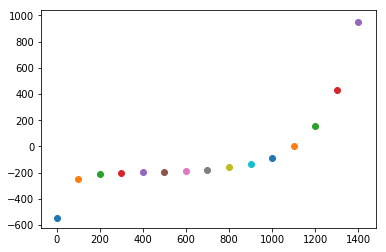

In [183]:
max_iterations = 1500

# inducing point location
Zx = np.linspace(0, 20, 11)[:,na]
Zy = np.linspace(0, 10, 11)[:,na]

Z = np.concatenate((Zx,Zy),axis=1)

X = np.random.rand(10,2)

wr_means = []
wr_covar = []

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('logs', sess.graph)
    
    for i in range(max_iterations):
        _, summary, kl, integral,bound, m_val, S_val = sess.run([train_step, merged,  kl_term_op, integral_over_T ,lower_bound, m, S], 
                                                     feed_dict={Z_ph:Z, u_ph:0.,X_ph:X})
        writer.add_summary(summary, i)
        
        if i % 100 == 0:
            print('..........')
            print(kl)
            print(integral)
            print(bound)
            #print(np.max(np.absolute(S_val)))
            #print(np.all(np.linalg.eigvals(S_val) > 0))
            
            plt.scatter(i, bound)
            
        if np.isclose(kl, 0):
            print('KL is zero after {} iterations... break'.format(i))
            break

plt.show()

In [ ]:
def ard_kernel_np(X1, X2, gamma = 1., alphas = None):
    
    if alphas == None:
        alphas = np.ones(X1.shape[1])
    
    return gamma * np.prod(np.exp( - (X1[:,None,:] - X2[None,:,:])**2 / (2 * alphas[None,None,:])), axis=2)

In [ ]:
# TEST

r_mean = np.zeros(num_inducing_points)
r_cov = ard_kernel_np(Z, Z)

print(np.allclose(r_mean, m_val))
print(np.allclose(r_cov, S_val))

print(np.sum(r_cov - S_val)**2)

# values not allclose but almost the same

### example sampling:

In [ ]:
# sampling
num_samples = 10

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter('logs', sess.graph)
    sample_res, mean_res, cov_res = sess.run([samples, mean, cov], feed_dict={Z_ph:Z, u_ph:0., n_ph:num_samples})

In [ ]:
for i in range(num_samples):
    plt.plot(Z, sample_res[i])
plt.show()

# Planning:

# 1. Inputs:
Domain $X = \mathbb{R}^R$ ($R$-Dimensional)
$T \subset X$


### Fixed:

#### General:
- R
- Tlims: (Rx2)
- Data D: (NxR) (all points in T)

#### Inducing points:
    -> fix nbr M 
    -> Z: (MxR) location
    -> u: (M) (each sample of function values at the inducing points is M dimensional) 

#### Hyperparameters ($\Theta$)
    -> fixed at first, might become be optimized later as well
$\Theta = (\gamma, \alpha_1,...,  \alpha_R, \overline{u})$


### Parameters:
variational dist at inducing points u: q(u) = N (u;m,S)

m: (M)

S: (MxM)

In [ ]:
# pseudo stuff, no working code!!!

# constants:
# - R, T, M
# - D (NxR)
# - Z (MxR)
# - Theta values (gamma, alphas, ustrich)

# placeholders:
# - m (M)
# - S (MxM)


# kernel stuff:

def kernel_function(X, Y):
    return K_XY

# kernels to compute: K_zz, K_zd, trace(K_dd)

def lower_bound(D, m, S, Theta, T):
    K_zz = ...
    K_zz_inv = ...
    
    return - region_integral(m, S, K_zz_inv, Z, Theta, T) + datapoint_expectations(D, m, S, K_zz_inv, Theta) - kl_term(m,S,K_zz, K_zz_inv, Theta) 

def kl_term(m, S, K_zz, K_zz_inv, Theta):
    return scalar_value_node

def datapoint_expectations(D, m, S, K_zz_inv, Theta):
    
    k_zd = ...
    k_dd = ...
    
    musqare_N = ...
    sigsquare_N = ...
    
    C = 0.57721... #Euler-Masceroni constant
    
    lookup values = ... # problem: how to implement lookup table
    
    return scalar_value_node

def region_integral(m, S, K_zz_inv, Z, Theta, T):
    Psi = ... (MxM) 
    return scalar_value_node